# Imports Tab

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration's 

In [2]:
# =====================
# CONFIGURATION
# =====================
config = {
    "model": "mobilenetv2",   # Options: mobilenetv2, convnext, dct, stft, wavelet, learnable_freq
    "epochs": 50,
    "batch_size": 32,
    "lr": 1e-3,
    "early_stopping_patience": 5,
    "dropout": 0.5,
    "num_classes": 5,  # update based on dataset
    "train_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\train",
    "val_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\val",
    "test_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\test",
}

# =====================
# DATA PIPELINE
# =====================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(config["train_dir"], transform=transform)
val_data = datasets.ImageFolder(config["val_dir"], transform=transform)
test_data = datasets.ImageFolder(config["test_dir"], transform=transform)

train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_data, batch_size=config["batch_size"], shuffle=False)
test_loader = DataLoader(test_data, batch_size=config["batch_size"], shuffle=False)

# =====================
# DEVICE
# =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [ ]:
# =====================
# MODEL BUILDER
# =====================
class ClassifierHead(nn.Module):
    def __init__(self, in_features, num_classes, dropout=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

def build_model(config):
    if config["model"] == "mobilenetv2":
        base = models.mobilenet_v2(weights="IMAGENET1K_V1")
        in_features = base.classifier[1].in_features
        base.classifier = ClassifierHead(in_features, config["num_classes"], config["dropout"])
        return base

    elif config["model"] == "convnext":
        base = models.convnext_tiny(weights="IMAGENET1K_V1")
        in_features = base.classifier[2].in_features
        base.classifier[2] = nn.Linear(in_features, config["num_classes"])
        return base

    elif config["model"] == "dct":
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(224*224*3, 512),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(512, config["num_classes"])
        )

    elif config["model"] == "stft":
        return nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(16, config["num_classes"])
        )

    elif config["model"] == "wavelet":
        return nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, config["num_classes"])
        )

    elif config["model"] == "learnable_freq":
        return nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, config["num_classes"])
        )

    else:
        raise ValueError(f"Unknown model type: {config['model']}")


model = build_model(config).to(device)

In [ ]:
# =====================
# TRAINING SETUP
# =====================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["lr"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

best_val_loss = np.inf
best_val_auc = -np.inf

patience_counter = 0

# For tracking
history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": [],
    "train_prec": [], "val_prec": [],
    "train_rec": [], "val_rec": [],
    "train_f1": [], "val_f1": [],
    "train_auc": [], "val_auc": []
}

# =====================
# HELPER FUNCTIONS
# =====================
def compute_metrics(y_true, y_pred, y_prob, average="macro"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class="ovr")
    except:
        auc = 0.0
    return acc, prec, rec, f1, auc

# =====================
# TRAINING LOOP
# =====================
for epoch in range(config["epochs"]):
    # -------- TRAIN --------
    model.train()
    train_loss, train_preds, train_labels, train_probs = 0, [], [], []
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        probs = torch.softmax(preds, dim=1)
        train_preds.extend(torch.argmax(preds, 1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        train_probs.extend(probs.cpu().detach().numpy())

    train_loss /= len(train_loader)
    train_acc, train_prec, train_rec, train_f1, train_auc = compute_metrics(
        train_labels, train_preds, train_probs
    )

    # -------- VALIDATION --------
    model.eval()
    val_loss, val_preds, val_labels, val_probs = 0, [], [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Val]"):
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            val_loss += loss.item()
            probs = torch.softmax(preds, dim=1)
            val_preds.extend(torch.argmax(preds, 1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc, val_prec, val_rec, val_f1, val_auc = compute_metrics(
        val_labels, val_preds, val_probs
    )

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_prec"].append(train_prec)
    history["val_prec"].append(val_prec)
    history["train_rec"].append(train_rec)
    history["val_rec"].append(val_rec)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)
    history["train_auc"].append(train_auc)
    history["val_auc"].append(val_auc)

    # Print like your screenshot
    print(f"\nEpoch {epoch+1}:")
    print(f" Train -> Loss={train_loss:.4f}, Acc={train_acc:.4f}, Prec={train_prec:.4f}, "
          f"Rec={train_rec:.4f}, F1={train_f1:.4f}, AUC={train_auc:.4f}")
    print(f" Val   -> Loss={val_loss:.4f}, Acc={val_acc:.4f}, Prec={val_prec:.4f}, "
          f"Rec={val_rec:.4f}, F1={val_f1:.4f}, AUC={val_auc:.4f}")

    # Save best model
    # Save best model based on AUC
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_auc.pth")
        print(f"Best model (AUC) saved with AUC = {best_val_auc:.4f}")
    else:
        print(f"Validation Loss {val_auc:.4f} did not improved from {best_val_auc:.4f}")

    # Save best model based on Loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model_loss.pth")
        print(f"Best model (Loss) saved with Loss = {best_val_loss:.4f}")
    else:
        print(f"Validation Loss {val_loss:.4f} did not reduced from {best_val_loss:.4f}")

    # Early stopping (based on AUC, but can be based on loss too)
    if val_auc <= best_val_auc:
        patience_counter += 1
        if patience_counter >= config["early_stopping_patience"]:
            print("Early stopping triggered!")
            break

Epoch 1/50 [Val]: 100%|██████████| 84/84 [00:28<00:00,  2.96it/s]



Epoch 1:
 Train -> Loss=0.8959, Acc=0.7108, Prec=0.5094, Rec=0.4784, F1=0.4911, AUC=0.8444
 Val   -> Loss=0.6464, Acc=0.7842, Prec=0.7037, Rec=0.5595, F1=0.5512, AUC=0.9257
Best model (AUC) saved with AUC = 0.9257
Best model (Loss) saved with Loss = 0.6464


Epoch 2/50 [Val]: 100%|██████████| 84/84 [00:24<00:00,  3.40it/s]



Epoch 2:
 Train -> Loss=0.7068, Acc=0.7592, Prec=0.5860, Rec=0.5443, F1=0.5595, AUC=0.9002
 Val   -> Loss=0.6655, Acc=0.7731, Prec=0.6895, Rec=0.5483, F1=0.5713, AUC=0.9108
Validation Loss 0.9108 did not improved from 0.9257
Validation Loss 0.6655 did not reduced from 0.6464


Epoch 3/50 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.89it/s]



Epoch 3:
 Train -> Loss=0.5690, Acc=0.8033, Prec=0.6727, Rec=0.6263, F1=0.6451, AUC=0.9320
 Val   -> Loss=0.5019, Acc=0.8259, Prec=0.7278, Rec=0.6272, F1=0.6366, AUC=0.9479
Best model (AUC) saved with AUC = 0.9479
Best model (Loss) saved with Loss = 0.5019


Epoch 4/50 [Val]: 100%|██████████| 84/84 [00:22<00:00,  3.81it/s]



Epoch 4:
 Train -> Loss=0.5102, Acc=0.8225, Prec=0.7031, Rec=0.6637, F1=0.6804, AUC=0.9433
 Val   -> Loss=0.5888, Acc=0.7965, Prec=0.7559, Rec=0.5603, F1=0.6027, AUC=0.9408
Validation Loss 0.9408 did not improved from 0.9479
Validation Loss 0.5888 did not reduced from 0.5019


Epoch 5/50 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.10it/s]



Epoch 5:
 Train -> Loss=0.4820, Acc=0.8303, Prec=0.7163, Rec=0.6799, F1=0.6957, AUC=0.9503
 Val   -> Loss=0.5494, Acc=0.8058, Prec=0.7239, Rec=0.6056, F1=0.6167, AUC=0.9400
Validation Loss 0.9400 did not improved from 0.9479
Validation Loss 0.5494 did not reduced from 0.5019


Epoch 6/50 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.08it/s]



Epoch 6:
 Train -> Loss=0.4604, Acc=0.8378, Prec=0.7296, Rec=0.6977, F1=0.7118, AUC=0.9548
 Val   -> Loss=0.5053, Acc=0.8348, Prec=0.7346, Rec=0.6883, F1=0.7051, AUC=0.9493
Best model (AUC) saved with AUC = 0.9493
Validation Loss 0.5053 did not reduced from 0.5019


Epoch 7/50 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.05it/s]



Epoch 7:
 Train -> Loss=0.4188, Acc=0.8526, Prec=0.7527, Rec=0.7219, F1=0.7356, AUC=0.9627
 Val   -> Loss=0.5786, Acc=0.8337, Prec=0.7547, Rec=0.6595, F1=0.6916, AUC=0.9405
Validation Loss 0.9405 did not improved from 0.9493
Validation Loss 0.5786 did not reduced from 0.5019


Epoch 8/50 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.05it/s]



Epoch 8:
 Train -> Loss=0.3861, Acc=0.8652, Prec=0.7744, Rec=0.7494, F1=0.7607, AUC=0.9678
 Val   -> Loss=0.6064, Acc=0.8106, Prec=0.6981, Rec=0.6622, F1=0.6441, AUC=0.9318
Validation Loss 0.9318 did not improved from 0.9493
Validation Loss 0.6064 did not reduced from 0.5019


Epoch 9/50 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.07it/s]



Epoch 9:
 Train -> Loss=0.3885, Acc=0.8648, Prec=0.7769, Rec=0.7486, F1=0.7615, AUC=0.9675
 Val   -> Loss=0.6061, Acc=0.8144, Prec=0.7181, Rec=0.6426, F1=0.6547, AUC=0.9358
Validation Loss 0.9358 did not improved from 0.9493
Validation Loss 0.6061 did not reduced from 0.5019


Epoch 10/50 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.07it/s]


Epoch 10:
 Train -> Loss=0.3498, Acc=0.8745, Prec=0.7882, Rec=0.7646, F1=0.7756, AUC=0.9735
 Val   -> Loss=0.5804, Acc=0.8266, Prec=0.7430, Rec=0.6545, F1=0.6786, AUC=0.9473
Validation Loss 0.9473 did not improved from 0.9493
Validation Loss 0.5804 did not reduced from 0.5019
Early stopping triggered!



=== Test Results ===
 Loss=0.5028, Acc=0.8323, Prec=0.7366, Rec=0.6828, F1=0.7039, AUC=0.9484, Spec=0.9450


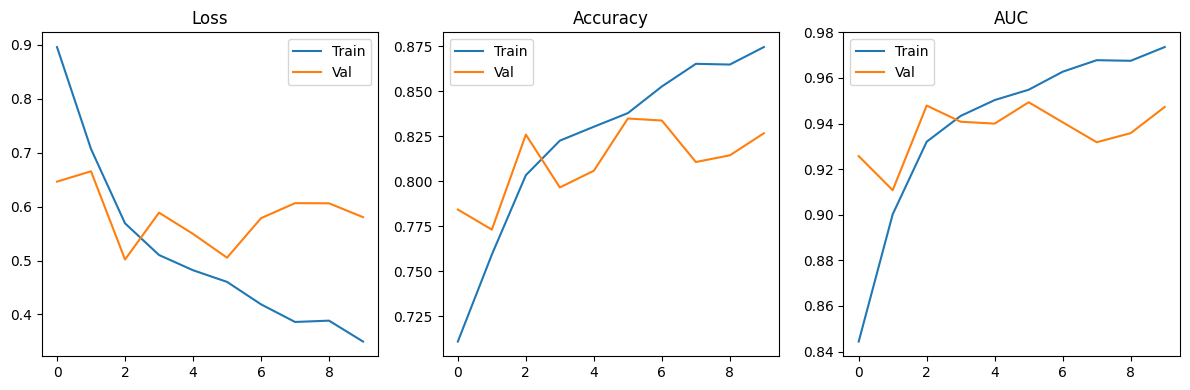

In [5]:
# =====================
# TESTING
# =====================
model_path = r"F:\final project\Capstone Prj\Notebooks\best_model_auc.pth"
model.load_state_dict(torch.load(model_path))
model.eval()
test_loss, test_preds, test_labels, test_probs = 0, [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        test_loss += loss.item()
        probs = torch.softmax(preds, dim=1)
        test_preds.extend(torch.argmax(preds, 1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_loss /= len(test_loader)
test_acc, test_prec, test_rec, test_f1, test_auc = compute_metrics(test_labels, test_preds, test_probs)

# Specificity (per class, averaged)
cm = confusion_matrix(test_labels, test_preds)
tn = cm.sum() - (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
fp = cm.sum(axis=0) - np.diag(cm)
specificity = np.mean(tn / (tn + fp + 1e-8))

print("\n=== Test Results ===")
print(f" Loss={test_loss:.4f}, Acc={test_acc:.4f}, Prec={test_prec:.4f}, "
      f"Rec={test_rec:.4f}, F1={test_f1:.4f}, AUC={test_auc:.4f}, Spec={specificity:.4f}")

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.close()

# =====================
# FINAL SUMMARY PLOT
# =====================
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history["train_auc"], label="Train")
plt.plot(history["val_auc"], label="Val")
plt.title("AUC")
plt.legend()

plt.tight_layout()
plt.savefig("summary.png")
plt.show()

Using cuda


Epoch 1/50 [Val]: 100%|██████████| 84/84 [00:23<00:00,  3.58it/s]



Epoch 1:
 Train -> Loss=0.8844, Acc=0.7164, Prec=0.5222, Rec=0.4982, F1=0.5087, AUC=0.8471
 Val   -> Loss=0.8568, Acc=0.7481, Prec=0.5775, Rec=0.5480, F1=0.5399, AUC=0.8766
Best model (AUC) saved with AUC = 0.8766
Best model (Loss) saved with Loss = 0.8568


Epoch 2/50 [Val]: 100%|██████████| 84/84 [00:23<00:00,  3.51it/s]



Epoch 2:
 Train -> Loss=0.6627, Acc=0.7797, Prec=0.6214, Rec=0.5847, F1=0.6007, AUC=0.9089
 Val   -> Loss=0.5962, Acc=0.7939, Prec=0.6927, Rec=0.6115, F1=0.6306, AUC=0.9276
Best model (AUC) saved with AUC = 0.9276
Best model (Loss) saved with Loss = 0.5962


Epoch 3/50 [Val]: 100%|██████████| 84/84 [00:22<00:00,  3.67it/s]



Epoch 3:
 Train -> Loss=0.5985, Acc=0.7976, Prec=0.6529, Rec=0.6189, F1=0.6341, AUC=0.9247
 Val   -> Loss=0.7353, Acc=0.8110, Prec=0.6810, Rec=0.6444, F1=0.6470, AUC=0.9102
Validation AUC 0.9102 did not improve from 0.9276
Validation Loss 0.7353 did not reduce from 0.5962


Epoch 4/50 [Val]: 100%|██████████| 84/84 [00:22<00:00,  3.66it/s]



Epoch 4:
 Train -> Loss=0.5557, Acc=0.8101, Prec=0.6732, Rec=0.6355, F1=0.6521, AUC=0.9339
 Val   -> Loss=0.6076, Acc=0.8132, Prec=0.6906, Rec=0.6714, F1=0.6722, AUC=0.9375
Best model (AUC) saved with AUC = 0.9375
Validation Loss 0.6076 did not reduce from 0.5962


Epoch 5/50 [Val]: 100%|██████████| 84/84 [00:23<00:00,  3.65it/s]



Epoch 5:
 Train -> Loss=0.5013, Acc=0.8303, Prec=0.7142, Rec=0.6793, F1=0.6949, AUC=0.9468
 Val   -> Loss=0.5921, Acc=0.7898, Prec=0.6704, Rec=0.6252, F1=0.6273, AUC=0.9332
Validation AUC 0.9332 did not improve from 0.9375
Best model (Loss) saved with Loss = 0.5921


Epoch 6/50 [Val]: 100%|██████████| 84/84 [00:23<00:00,  3.65it/s]



Epoch 6:
 Train -> Loss=0.4941, Acc=0.8300, Prec=0.7118, Rec=0.6772, F1=0.6923, AUC=0.9475
 Val   -> Loss=0.4963, Acc=0.8322, Prec=0.7098, Rec=0.7384, F1=0.7226, AUC=0.9548
Best model (AUC) saved with AUC = 0.9548
Best model (Loss) saved with Loss = 0.4963


Epoch 7/50 [Val]: 100%|██████████| 84/84 [00:23<00:00,  3.54it/s]



Epoch 7:
 Train -> Loss=0.4407, Acc=0.8509, Prec=0.7487, Rec=0.7193, F1=0.7328, AUC=0.9582
 Val   -> Loss=0.5724, Acc=0.8110, Prec=0.7057, Rec=0.6512, F1=0.6712, AUC=0.9424
Validation AUC 0.9424 did not improve from 0.9548
Validation Loss 0.5724 did not reduce from 0.4963


Epoch 8/50 [Val]: 100%|██████████| 84/84 [00:22<00:00,  3.65it/s]



Epoch 8:
 Train -> Loss=0.4197, Acc=0.8526, Prec=0.7526, Rec=0.7248, F1=0.7376, AUC=0.9630
 Val   -> Loss=0.5404, Acc=0.8400, Prec=0.7399, Rec=0.6971, F1=0.7108, AUC=0.9483
Validation AUC 0.9483 did not improve from 0.9548
Validation Loss 0.5404 did not reduce from 0.4963


Epoch 9/50 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.13it/s]



Epoch 9:
 Train -> Loss=0.3735, Acc=0.8714, Prec=0.7819, Rec=0.7583, F1=0.7693, AUC=0.9698
 Val   -> Loss=0.5507, Acc=0.8170, Prec=0.6885, Rec=0.6565, F1=0.6651, AUC=0.9425
Validation AUC 0.9425 did not improve from 0.9548
Validation Loss 0.5507 did not reduce from 0.4963


Epoch 10/50 [Val]: 100%|██████████| 84/84 [00:47<00:00,  1.76it/s]



Epoch 10:
 Train -> Loss=0.3419, Acc=0.8800, Prec=0.7898, Rec=0.7703, F1=0.7794, AUC=0.9747
 Val   -> Loss=0.5709, Acc=0.8315, Prec=0.7098, Rec=0.6746, F1=0.6869, AUC=0.9423
Validation AUC 0.9423 did not improve from 0.9548
Validation Loss 0.5709 did not reduce from 0.4963
Early stopping triggered!

=== Test Results ===
 Loss=0.4859, Acc=0.8346, Prec=0.7073, Rec=0.7255, F1=0.7153, AUC=0.9529, Spec=0.9545


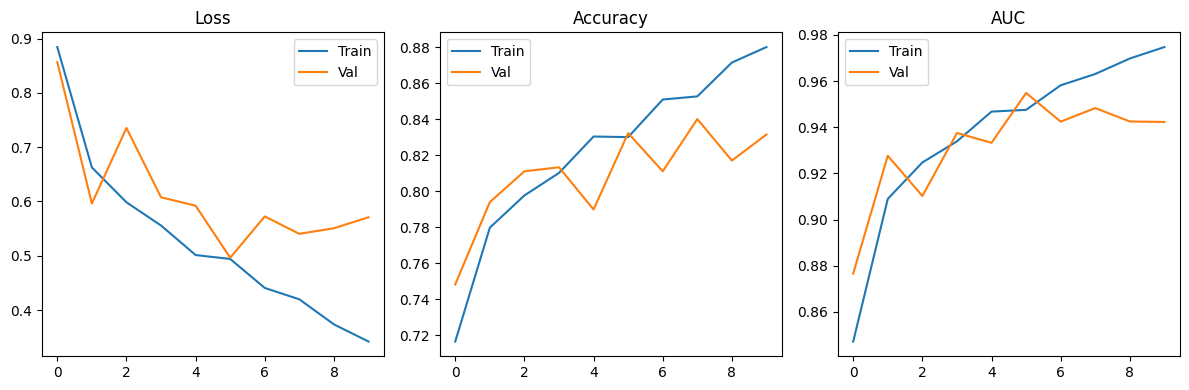

In [ ]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# =====================
# CONFIGURATION
# =====================
config = {
    "model": "mobilenetv2",   # Options: mobilenetv2, convnext
    "epochs": 50,
    "batch_size": 32,
    "lr": 1e-3,
    "early_stopping_patience": 5,
    "dropout": 0.5,
    "num_classes": 5,  # update based on dataset
    "train_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\train",
    "val_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\val",
    "test_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\test",
}
config["save_dir"] = os.path.join("models", config["model"])
os.makedirs(config["save_dir"], exist_ok=True)

print(f"Models will be saved in: {config['save_dir']}")
config["model_path_auc"] = os.path.join(config["save_dir"], "best_auc.pth")
config["model_path_loss"] = os.path.join(config["save_dir"], "best_loss.pth")

# =====================
# DATA PIPELINE
# =====================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(config["train_dir"], transform=transform)
val_data = datasets.ImageFolder(config["val_dir"], transform=transform)
test_data = datasets.ImageFolder(config["test_dir"], transform=transform)

train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_data, batch_size=config["batch_size"], shuffle=False)
test_loader = DataLoader(test_data, batch_size=config["batch_size"], shuffle=False)

# =====================
# DEVICE
# =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# =====================
# MODEL BUILDER
# =====================
class ClassifierHead(nn.Module):
    def __init__(self, in_features, num_classes, dropout=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

def build_model(config):
    if config["model"] == "mobilenetv2":
        base = models.mobilenet_v2(weights="IMAGENET1K_V1")
        in_features = base.classifier[1].in_features
        base.classifier = ClassifierHead(in_features, config["num_classes"], config["dropout"])
        return base

    elif config["model"] == "convnext":
        base = models.convnext_tiny(weights="IMAGENET1K_V1")
        in_features = base.classifier[2].in_features
        base.classifier[2] = nn.Linear(in_features, config["num_classes"])
        return base

    elif config["model"] == "dct":
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(224*224*3, 512),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(512, config["num_classes"])
        )

    elif config["model"] == "stft":
        return nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(16, config["num_classes"])
        )

    elif config["model"] == "wavelet":
        return nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, config["num_classes"])
        )

    elif config["model"] == "learnable_freq":
        return nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, config["num_classes"])
        )

    else:
        raise ValueError(f"Unknown model type: {config['model']}")

model = build_model(config).to(device)

# =====================
# TRAINING SETUP
# =====================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["lr"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

best_val_loss = np.inf
best_val_auc = -np.inf
patience_counter = 0

# For tracking
history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": [],
    "train_prec": [], "val_prec": [],
    "train_rec": [], "val_rec": [],
    "train_f1": [], "val_f1": [],
    "train_auc": [], "val_auc": []
}

# Adding SEED 
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# =====================
# HELPER FUNCTIONS
# =====================
def compute_metrics(y_true, y_pred, y_prob, average="macro"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class="ovr")
    except:
        auc = 0.0
    return acc, prec, rec, f1, auc

# =====================
# TRAINING LOOP
# =====================
for epoch in range(config["epochs"]):
    # -------- TRAIN --------
    model.train()
    train_loss, train_preds, train_labels, train_probs = 0, [], [], []
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        probs = torch.softmax(preds, dim=1)
        train_preds.extend(torch.argmax(preds, 1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        train_probs.extend(probs.cpu().detach().numpy())

    train_loss /= len(train_loader)
    train_acc, train_prec, train_rec, train_f1, train_auc = compute_metrics(
        train_labels, train_preds, train_probs
    )

    # -------- VALIDATION --------
    model.eval()
    val_loss, val_preds, val_labels, val_probs = 0, [], [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Val]"):
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            val_loss += loss.item()
            probs = torch.softmax(preds, dim=1)
            val_preds.extend(torch.argmax(preds, 1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc, val_prec, val_rec, val_f1, val_auc = compute_metrics(
        val_labels, val_preds, val_probs
    )

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_prec"].append(train_prec)
    history["val_prec"].append(val_prec)
    history["train_rec"].append(train_rec)
    history["val_rec"].append(val_rec)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)
    history["train_auc"].append(train_auc)
    history["val_auc"].append(val_auc)

    # Print results like your screenshot
    print(f"\nEpoch {epoch+1}:")
    print(f" Train -> Loss={train_loss:.4f}, Acc={train_acc:.4f}, Prec={train_prec:.4f}, "
          f"Rec={train_rec:.4f}, F1={train_f1:.4f}, AUC={train_auc:.4f}")
    print(f" Val   -> Loss={val_loss:.4f}, Acc={val_acc:.4f}, Prec={val_prec:.4f}, "
          f"Rec={val_rec:.4f}, F1={val_f1:.4f}, AUC={val_auc:.4f}")

    # Save best model based on AUC
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save(model.state_dict(), config["model_path_auc"])
        print(f"Best model (AUC) saved with AUC = {best_val_auc:.4f}")
    else:
        print(f"Validation AUC {val_auc:.4f} did not improve from {best_val_auc:.4f}")

    # Save best model based on Loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), config["model_path_loss"])
        print(f"Best model (Loss) saved with Loss = {best_val_loss:.4f}")
    else:
        print(f"Validation Loss {val_loss:.4f} did not reduced from {best_val_loss:.4f}")

    # Early stopping (based on AUC)
    if val_auc <= best_val_auc:
        patience_counter += 1
        if patience_counter >= config["early_stopping_patience"]:
            print("Early stopping triggered!")
            break

    # Save plots every epoch
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history["train_loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history["train_acc"], label="Train")
    plt.plot(history["val_acc"], label="Val")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history["train_auc"], label="Train")
    plt.plot(history["val_auc"], label="Val")
    plt.title("AUC")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"epoch_{epoch+1}_plots.png")
    plt.close()

# =====================
# TESTING
# =====================
model_path = "best_model_auc.pth"  # load best by AUC
model.load_state_dict(torch.load(model_path))
model.eval()
test_loss, test_preds, test_labels, test_probs = 0, [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        test_loss += loss.item()
        probs = torch.softmax(preds, dim=1)
        test_preds.extend(torch.argmax(preds, 1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_loss /= len(test_loader)
test_acc, test_prec, test_rec, test_f1, test_auc = compute_metrics(test_labels, test_preds, test_probs)

# Specificity (macro-averaged)
cm = confusion_matrix(test_labels, test_preds)
tn = cm.sum() - (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
fp = cm.sum(axis=0) - np.diag(cm)
specificity = np.mean(tn / (tn + fp + 1e-8))

print("\n=== Test Results ===")
print(f" Loss={test_loss:.4f}, Acc={test_acc:.4f}, Prec={test_prec:.4f}, "
      f"Rec={test_rec:.4f}, F1={test_f1:.4f}, AUC={test_auc:.4f}, Spec={specificity:.4f}")

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.close()

# =====================
# FINAL SUMMARY PLOT
# =====================
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history["train_auc"], label="Train")
plt.plot(history["val_auc"], label="Val")
plt.title("AUC")
plt.legend()

plt.tight_layout()
plt.savefig("summary.png")
plt.show()


Using cuda


Epoch 1/60 [Val]: 100%|██████████| 84/84 [00:23<00:00,  3.53it/s]



Epoch 1:
 Train -> Loss=0.9321, Acc=0.6940, Prec=0.4804, Rec=0.4474, F1=0.4596, AUC=0.8277
 Val   -> Loss=0.7511, Acc=0.7693, Prec=0.6566, Rec=0.5849, F1=0.5890, AUC=0.9023
Best model (AUC) saved with AUC = 0.9023
Best model (Loss) saved with Loss = 0.7511


Epoch 2/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.91it/s]



Epoch 2:
 Train -> Loss=0.7620, Acc=0.7434, Prec=0.5634, Rec=0.5193, F1=0.5376, AUC=0.8822
 Val   -> Loss=0.6835, Acc=0.7433, Prec=0.5976, Rec=0.5316, F1=0.5024, AUC=0.9217
Best model (AUC) saved with AUC = 0.9217
Best model (Loss) saved with Loss = 0.6835


Epoch 3/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.97it/s]



Epoch 3:
 Train -> Loss=0.6983, Acc=0.7638, Prec=0.5926, Rec=0.5496, F1=0.5667, AUC=0.8975
 Val   -> Loss=0.8147, Acc=0.7701, Prec=0.6462, Rec=0.5787, F1=0.5497, AUC=0.8600
Validation AUC 0.8600 did not improve from 0.9217
Validation Loss 0.8147 did not reduce from 0.6835


Epoch 4/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.99it/s]



Epoch 4:
 Train -> Loss=0.6331, Acc=0.7813, Prec=0.6225, Rec=0.5795, F1=0.5973, AUC=0.9142
 Val   -> Loss=0.5994, Acc=0.8244, Prec=0.7117, Rec=0.6620, F1=0.6725, AUC=0.9312
Best model (AUC) saved with AUC = 0.9312
Best model (Loss) saved with Loss = 0.5994


Epoch 5/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.96it/s]



Epoch 5:
 Train -> Loss=0.5598, Acc=0.8036, Prec=0.6659, Rec=0.6247, F1=0.6421, AUC=0.9327
 Val   -> Loss=0.4606, Acc=0.8482, Prec=0.7688, Rec=0.6988, F1=0.7212, AUC=0.9533
Best model (AUC) saved with AUC = 0.9533
Best model (Loss) saved with Loss = 0.4606


Epoch 6/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.98it/s]



Epoch 6:
 Train -> Loss=0.5138, Acc=0.8202, Prec=0.6990, Rec=0.6608, F1=0.6774, AUC=0.9438
 Val   -> Loss=0.4741, Acc=0.8408, Prec=0.7755, Rec=0.6614, F1=0.6603, AUC=0.9556
Best model (AUC) saved with AUC = 0.9556
Validation Loss 0.4741 did not reduce from 0.4606


Epoch 7/60 [Val]: 100%|██████████| 84/84 [00:22<00:00,  3.76it/s]



Epoch 7:
 Train -> Loss=0.4764, Acc=0.8338, Prec=0.7228, Rec=0.6832, F1=0.7003, AUC=0.9511
 Val   -> Loss=0.4588, Acc=0.8434, Prec=0.7690, Rec=0.7029, F1=0.7147, AUC=0.9595
Best model (AUC) saved with AUC = 0.9595
Best model (Loss) saved with Loss = 0.4588


Epoch 8/60 [Val]: 100%|██████████| 84/84 [00:22<00:00,  3.72it/s]



Epoch 8:
 Train -> Loss=0.4350, Acc=0.8511, Prec=0.7526, Rec=0.7121, F1=0.7297, AUC=0.9584
 Val   -> Loss=0.4319, Acc=0.8504, Prec=0.7444, Rec=0.7538, F1=0.7430, AUC=0.9612
Best model (AUC) saved with AUC = 0.9612
Best model (Loss) saved with Loss = 0.4319


Epoch 9/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.89it/s]



Epoch 9:
 Train -> Loss=0.4047, Acc=0.8609, Prec=0.7737, Rec=0.7394, F1=0.7550, AUC=0.9639
 Val   -> Loss=0.4135, Acc=0.8631, Prec=0.7748, Rec=0.7426, F1=0.7544, AUC=0.9623
Best model (AUC) saved with AUC = 0.9623
Best model (Loss) saved with Loss = 0.4135


Epoch 10/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.99it/s]



Epoch 10:
 Train -> Loss=0.3836, Acc=0.8660, Prec=0.7794, Rec=0.7504, F1=0.7637, AUC=0.9670
 Val   -> Loss=0.4048, Acc=0.8735, Prec=0.7882, Rec=0.7639, F1=0.7735, AUC=0.9643
Best model (AUC) saved with AUC = 0.9643
Best model (Loss) saved with Loss = 0.4048


Epoch 11/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.92it/s]



Epoch 11:
 Train -> Loss=0.3722, Acc=0.8691, Prec=0.7870, Rec=0.7523, F1=0.7684, AUC=0.9690
 Val   -> Loss=0.4046, Acc=0.8731, Prec=0.7906, Rec=0.7575, F1=0.7695, AUC=0.9643
Best model (AUC) saved with AUC = 0.9643
Best model (Loss) saved with Loss = 0.4046


Epoch 12/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.98it/s]



Epoch 12:
 Train -> Loss=0.3819, Acc=0.8683, Prec=0.7812, Rec=0.7517, F1=0.7652, AUC=0.9671
 Val   -> Loss=0.3987, Acc=0.8728, Prec=0.7849, Rec=0.7539, F1=0.7659, AUC=0.9648
Best model (AUC) saved with AUC = 0.9648
Best model (Loss) saved with Loss = 0.3987


Epoch 13/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.89it/s]



Epoch 13:
 Train -> Loss=0.3825, Acc=0.8646, Prec=0.7774, Rec=0.7445, F1=0.7596, AUC=0.9676
 Val   -> Loss=0.4139, Acc=0.8676, Prec=0.7795, Rec=0.7524, F1=0.7628, AUC=0.9629
Validation AUC 0.9629 did not improve from 0.9648
Validation Loss 0.4139 did not reduce from 0.3987


Epoch 14/60 [Val]: 100%|██████████| 84/84 [00:33<00:00,  2.53it/s]



Epoch 14:
 Train -> Loss=0.4087, Acc=0.8522, Prec=0.7551, Rec=0.7266, F1=0.7396, AUC=0.9639
 Val   -> Loss=0.4345, Acc=0.8564, Prec=0.7759, Rec=0.7371, F1=0.7491, AUC=0.9613
Validation AUC 0.9613 did not improve from 0.9648
Validation Loss 0.4345 did not reduce from 0.3987


Epoch 15/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.95it/s]



Epoch 15:
 Train -> Loss=0.4411, Acc=0.8467, Prec=0.7477, Rec=0.7131, F1=0.7286, AUC=0.9582
 Val   -> Loss=0.5677, Acc=0.8158, Prec=0.7527, Rec=0.6107, F1=0.6126, AUC=0.9408
Validation AUC 0.9408 did not improve from 0.9648
Validation Loss 0.5677 did not reduce from 0.3987


Epoch 16/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.07it/s]



Epoch 16:
 Train -> Loss=0.4683, Acc=0.8357, Prec=0.7276, Rec=0.6887, F1=0.7058, AUC=0.9535
 Val   -> Loss=0.4960, Acc=0.8333, Prec=0.7329, Rec=0.7078, F1=0.7111, AUC=0.9545
Validation AUC 0.9545 did not improve from 0.9648
Validation Loss 0.4960 did not reduce from 0.3987


Epoch 17/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.98it/s]



Epoch 17:
 Train -> Loss=0.4136, Acc=0.8561, Prec=0.7627, Rec=0.7329, F1=0.7465, AUC=0.9623
 Val   -> Loss=0.4466, Acc=0.8594, Prec=0.7772, Rec=0.7200, F1=0.7359, AUC=0.9591
Validation AUC 0.9591 did not improve from 0.9648
Validation Loss 0.4466 did not reduce from 0.3987


Epoch 18/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.03it/s]



Epoch 18:
 Train -> Loss=0.4091, Acc=0.8573, Prec=0.7633, Rec=0.7326, F1=0.7463, AUC=0.9634
 Val   -> Loss=0.4597, Acc=0.8538, Prec=0.7617, Rec=0.7319, F1=0.7385, AUC=0.9569
Validation AUC 0.9569 did not improve from 0.9648
Validation Loss 0.4597 did not reduce from 0.3987
Early stopping triggered!

=== Test Results ===
 Loss=0.4033, Acc=0.8613, Prec=0.7545, Rec=0.7362, F1=0.7440, AUC=0.9638, Spec=0.9594


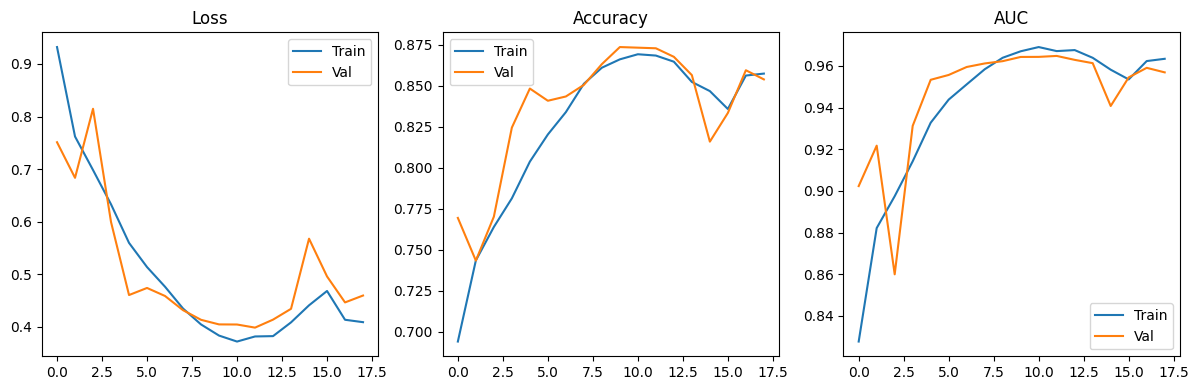

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# =====================
# CONFIGURATION
# =====================
config = {
    "model": "mobilenetv2",   # Options: mobilenetv2, convnext, dct, stft, wavelet, learnable_freq
    "epochs": 60,
    "batch_size": 32,
    "lr": 1e-3,
    "weight_decay": 1e-4,     # added for regularization
    "early_stopping_patience": 7,
    "dropout": 0.4,           # try 0.3, 0.4, 0.5
    "num_classes": 5,  # update based on dataset
    "train_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\train",
    "val_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\val",
    "test_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\test",
}

# =====================
# DATA PIPELINE
# =====================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(config["train_dir"], transform=train_transform)
val_data = datasets.ImageFolder(config["val_dir"], transform=test_transform)
test_data = datasets.ImageFolder(config["test_dir"], transform=test_transform)

train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_data, batch_size=config["batch_size"], shuffle=False)
test_loader = DataLoader(test_data, batch_size=config["batch_size"], shuffle=False)

# =====================
# DEVICE
# =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# =====================
# MODEL BUILDER
# =====================
class ClassifierHead(nn.Module):
    def __init__(self, in_features, num_classes, dropout=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

def build_model(config):
    if config["model"] == "mobilenetv2":
        base = models.mobilenet_v2(weights="IMAGENET1K_V1")
        in_features = base.classifier[1].in_features
        base.classifier = ClassifierHead(in_features, config["num_classes"], config["dropout"])
        return base

    elif config["model"] == "convnext":
        base = models.convnext_tiny(weights="IMAGENET1K_V1")
        in_features = base.classifier[2].in_features
        base.classifier[2] = nn.Linear(in_features, config["num_classes"])
        return base

    elif config["model"] == "dct":
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(224*224*3, 512),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(512, config["num_classes"])
        )

    elif config["model"] == "stft":
        return nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(16, config["num_classes"])
        )

    elif config["model"] == "wavelet":
        return nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, config["num_classes"])
        )

    elif config["model"] == "learnable_freq":
        return nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, config["num_classes"])
        )

    else:
        raise ValueError(f"Unknown model type: {config['model']}")

model = build_model(config).to(device)

# =====================
# TRAINING SETUP
# =====================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

# Scheduler: Reduce LR on plateau + Cosine Annealing
scheduler_plateau = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

best_val_loss = np.inf
best_val_auc = -np.inf
patience_counter = 0

# For tracking
history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": [],
    "train_prec": [], "val_prec": [],
    "train_rec": [], "val_rec": [],
    "train_f1": [], "val_f1": [],
    "train_auc": [], "val_auc": []
}

# =====================
# HELPER FUNCTIONS
# =====================
def compute_metrics(y_true, y_pred, y_prob, average="macro"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class="ovr")
    except:
        auc = 0.0
    return acc, prec, rec, f1, auc

# =====================
# TRAINING LOOP
# =====================
for epoch in range(config["epochs"]):
    # -------- TRAIN --------
    model.train()
    train_loss, train_preds, train_labels, train_probs = 0, [], [], []
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        probs = torch.softmax(preds, dim=1)
        train_preds.extend(torch.argmax(preds, 1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        train_probs.extend(probs.cpu().detach().numpy())

    train_loss /= len(train_loader)
    train_acc, train_prec, train_rec, train_f1, train_auc = compute_metrics(
        train_labels, train_preds, train_probs
    )

    # -------- VALIDATION --------
    model.eval()
    val_loss, val_preds, val_labels, val_probs = 0, [], [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Val]"):
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            val_loss += loss.item()
            probs = torch.softmax(preds, dim=1)
            val_preds.extend(torch.argmax(preds, 1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc, val_prec, val_rec, val_f1, val_auc = compute_metrics(
        val_labels, val_preds, val_probs
    )

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_prec"].append(train_prec)
    history["val_prec"].append(val_prec)
    history["train_rec"].append(train_rec)
    history["val_rec"].append(val_rec)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)
    history["train_auc"].append(train_auc)
    history["val_auc"].append(val_auc)

    # Print results
    print(f"\nEpoch {epoch+1}:")
    print(f" Train -> Loss={train_loss:.4f}, Acc={train_acc:.4f}, Prec={train_prec:.4f}, "
          f"Rec={train_rec:.4f}, F1={train_f1:.4f}, AUC={train_auc:.4f}")
    print(f" Val   -> Loss={val_loss:.4f}, Acc={val_acc:.4f}, Prec={val_prec:.4f}, "
          f"Rec={val_rec:.4f}, F1={val_f1:.4f}, AUC={val_auc:.4f}")

    # Save best model based on AUC
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_auc.pth")
        print(f"Best model (AUC) saved with AUC = {best_val_auc:.4f}")
    else:
        print(f"Validation AUC {val_auc:.4f} did not improve from {best_val_auc:.4f}")

    # Save best model based on Loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model_loss.pth")
        print(f"Best model (Loss) saved with Loss = {best_val_loss:.4f}")
    else:
        print(f"Validation Loss {val_loss:.4f} did not reduce from {best_val_loss:.4f}")

    # Step schedulers
    scheduler_plateau.step(val_loss)
    scheduler_cosine.step()

    # Early stopping (based on both)
    patience_counter += 1 if val_auc <= best_val_auc and val_loss >= best_val_loss else 0
    if patience_counter >= config["early_stopping_patience"]:
        print("Early stopping triggered!")
        break

    # Save plots every epoch
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history["train_loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history["train_acc"], label="Train")
    plt.plot(history["val_acc"], label="Val")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history["train_auc"], label="Train")
    plt.plot(history["val_auc"], label="Val")
    plt.title("AUC")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"epoch_{epoch+1}_plots.png")
    plt.close()

# =====================
# TESTING
# =====================
model_path = "best_model_auc.pth"  # load best by AUC
model.load_state_dict(torch.load(model_path))
model.eval()
test_loss, test_preds, test_labels, test_probs = 0, [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        test_loss += loss.item()
        probs = torch.softmax(preds, dim=1)
        test_preds.extend(torch.argmax(preds, 1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_loss /= len(test_loader)
test_acc, test_prec, test_rec, test_f1, test_auc = compute_metrics(test_labels, test_preds, test_probs)

# Specificity (macro-averaged)
cm = confusion_matrix(test_labels, test_preds)
tn = cm.sum() - (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
fp = cm.sum(axis=0) - np.diag(cm)
specificity = np.mean(tn / (tn + fp + 1e-8))

print("\n=== Test Results ===")
print(f" Loss={test_loss:.4f}, Acc={test_acc:.4f}, Prec={test_prec:.4f}, "
      f"Rec={test_rec:.4f}, F1={test_f1:.4f}, AUC={test_auc:.4f}, Spec={specificity:.4f}")

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.close()

# =====================
# FINAL SUMMARY PLOT
# =====================
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history["train_auc"], label="Train")
plt.plot(history["val_auc"], label="Val")
plt.title("AUC")
plt.legend()

plt.tight_layout()
plt.savefig("summary.png")
plt.show()
